# Using Reed.co.uk API to Get Job Data

This notebook demonstrates how to fetch job listings from Reed.co.uk API.

## Setup
Get your API key from: https://www.reed.co.uk/developers

## How to Run (clean flow)

1. Run cells 3–4 (imports + API key)
2. **Optional:** Run cell 5 to search for the 100 most recent remote jobs (otherwise cell 6 will fetch all jobs)
3. Run cells 6–10 to fetch job details, extract skills, visualize, and save to CSV/Azure
4. Run cell 11 to preview the data

**Note:** Azure database save may fail due to firewall restrictions. Data is always saved to CSV as a backup.

In [ ]:
# Import libraries
import requests
import pandas as pd
import base64 
import os

In [59]:
# Set up your Reed API key
# Prefer environment variable; fallback to hardcoded key if needed
API_KEY = os.getenv("REED_API_KEY") or "ff3b8ce7-3225-4336-911f-3b1ecad843ec"

# Reed API uses Basic Authentication with API key as username
# The password field should be left empty
auth_string = f"{API_KEY}:"
encoded_auth = base64.b64encode(auth_string.encode()).decode()

headers = {
    'Authorization': f'Basic {encoded_auth}'
}

In [60]:
# OPTIONAL: Find most recent 100 Data Analyst jobs referencing remote working
# Run this cell BEFORE the "Fetch FULL job details" cell to analyze remote jobs only
import re
import time

remote_regex = re.compile(r"\bremote\b|work\s*from\s*home|\bwfh\b|home[-\s]?based|home\s*working|homeworking|fully\s*remote|remote[-\s]?first", re.IGNORECASE)

search_url = 'https://www.reed.co.uk/api/1.0/search'

def page_search(keywords='data analyst', skip=0, take=100):
    params = {
        'keywords': keywords,
        'resultsToTake': take,
        'resultsToSkip': skip
    }
    r = requests.get(search_url, headers=headers, params=params)
    if r.status_code != 200:
        print(f"Search error {r.status_code}: {r.text[:200]}")
        return None
    return r.json()

print("Scanning pages to find the most recent 100 remote-friendly roles...")
remote_hits = []
page = 0
page_size = 100
max_pages = 30  # safety cap

while len(remote_hits) < 100 and page < max_pages:
    data = page_search('data analyst', skip=page*page_size, take=page_size)
    if not data or not data.get('results'):
        break
    results = data['results']
    for job in results:
        title = job.get('jobTitle','') or ''
        loc = job.get('locationName','') or ''
        desc = job.get('jobDescription','') or ''
        haystack = f"{title}\n{loc}\n{desc}"
        if remote_regex.search(haystack):
            remote_hits.append(job)
            if len(remote_hits) >= 100:
                break
    page += 1
    print(f"Pages scanned: {page}, remote matches so far: {len(remote_hits)}")
    time.sleep(0.1)

df_remote_jobs = pd.DataFrame(remote_hits)
if not df_remote_jobs.empty and 'date' in df_remote_jobs.columns:
    df_remote_jobs['date_parsed'] = pd.to_datetime(df_remote_jobs['date'], errors='coerce')
    df_remote_jobs = df_remote_jobs.sort_values('date_parsed', ascending=False)

# Keep top 100 most recent
df_remote_jobs = df_remote_jobs.head(100).reset_index(drop=True)

print(f"\n✅ Found {len(df_remote_jobs)} most recent 'data analyst' jobs referencing remote working")
print(df_remote_jobs[['jobId','jobTitle','locationName','date']].head(10))

# Save for convenience
df_remote_jobs.to_csv('reed_remote_data_analyst_jobs.csv', index=False)
print("💾 Saved to reed_remote_data_analyst_jobs.csv")

Scanning pages to find the most recent 100 remote-friendly roles...
Pages scanned: 1, remote matches so far: 4
Pages scanned: 1, remote matches so far: 4
Pages scanned: 2, remote matches so far: 6
Pages scanned: 2, remote matches so far: 6
Pages scanned: 3, remote matches so far: 7
Pages scanned: 3, remote matches so far: 7
Pages scanned: 4, remote matches so far: 11
Pages scanned: 4, remote matches so far: 11
Pages scanned: 5, remote matches so far: 20
Pages scanned: 5, remote matches so far: 20
Pages scanned: 6, remote matches so far: 26
Pages scanned: 6, remote matches so far: 26
Pages scanned: 7, remote matches so far: 35
Pages scanned: 7, remote matches so far: 35
Pages scanned: 8, remote matches so far: 39
Pages scanned: 8, remote matches so far: 39
Pages scanned: 9, remote matches so far: 47
Pages scanned: 9, remote matches so far: 47
Pages scanned: 10, remote matches so far: 59
Pages scanned: 10, remote matches so far: 59
Pages scanned: 11, remote matches so far: 69
Pages scann

In [61]:
# Search for Data Analyst jobs (fallback if remote jobs not searched)
def search_reed_jobs(keywords='data analyst', location='', results_to_take=100):
    """
    Search Reed.co.uk for jobs
    
    Parameters:
    - keywords: Job title or keywords to search for
    - location: Location (e.g., 'London', 'Manchester', or leave empty for all UK)
    - results_to_take: Number of results (max 100 per request)
    """
    
    base_url = 'https://www.reed.co.uk/api/1.0/search'
    
    params = {
        'keywords': keywords,
        'locationName': location,
        'resultsToTake': results_to_take,
        'resultsToSkip': 0
    }
    
    response = requests.get(base_url, headers=headers, params=params)
    
    if response.status_code == 200:
        data = response.json()
        print(f"Found {data['totalResults']} total jobs")
        print(f"Fetching {len(data['results'])} jobs")
        return data['results']
    else:
        print(f"Error: {response.status_code}")
        print(response.text)
        return []

# Fetch jobs
jobs_data = search_reed_jobs(keywords='data analyst', location='', results_to_take=100)
df_jobs = pd.DataFrame(jobs_data)

print(f"\nDataFrame shape: {df_jobs.shape}")
df_jobs.head()

Found 2532 total jobs
Fetching 100 jobs

DataFrame shape: (100, 15)


,jobId,employerId,employerName,employerProfileId,employerProfileName,jobTitle,locationName,minimumSalary,maximumSalary,currency,expirationDate,date,jobDescription,applications,jobUrl
0,55988131,685292,Smart4Chemicals,None,None,Data Analyst,Wigan,30000.0,35000.0,GBP,09/12/2025,28/10/2025,Data Analyst - Wigan Do you have experience wo...,215,https://www.reed.co.uk/jobs/data-analyst/55988131
1,56107225,690770,NG Bailey,None,None,Data Analyst,Leeds,NaN,NaN,None,02/01/2026,21/11/2025,Data Analyst (9-Month FTC) Location: Leeds (Hy...,79,https://www.reed.co.uk/jobs/data-analyst/56107225
2,56107954,328885,esure Group,None,None,Data Analyst,Reigate,NaN,NaN,None,02/01/2026,21/11/2025,Company Description Ready to join a team that'...,43,https://www.reed.co.uk/jobs/data-analyst/56107954
3,56094030,676328,Marley Risk Consultants Limited,None,None,Data Analyst,GL528YQ,35000.0,45000.0,GBP,31/12/2025,19/11/2025,Data Analyst Marley Risk Consultants Ltd are p...,151,https://www.reed.co.uk/jobs/data-analyst/56094030
4,55791736,585023,Marshall Wolfe,None,None,Data Strategy Analyst,London,65000.0,70000.0,GBP,22/12/2025,19/09/2025,Data Strategy Analyst - Decision Intelligence ...,433,https://www.reed.co.uk/jobs/data-strategy-anal...


In [62]:
# Fetch FULL job details for each job (this will give us complete descriptions)
import time

def get_job_details(job_id):
    """Get full details for a specific job including complete description"""
    url = f'https://www.reed.co.uk/api/1.0/jobs/{job_id}'
    response = requests.get(url, headers=headers)
    
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error fetching job {job_id}: {response.status_code}")
        return None

# Decide scope: use remote-filtered jobs if available, otherwise all jobs
use_remote_scope = 'df_remote_jobs' in globals() and isinstance(df_remote_jobs, pd.DataFrame) and not df_remote_jobs.empty

source_df = df_remote_jobs if use_remote_scope else df_jobs
scope_label = "REMOTE scope (most recent matches)" if use_remote_scope else "ALL jobs (first 100 from search)"
print(f"Fetching full job details using: {scope_label}")
print(f"Source jobs: {len(source_df)}")

print("Fetching full job details (this may take a minute)...")
full_jobs_data = []

for i, job_id in enumerate(source_df['jobId']):
    if i % 10 == 0:
        print(f"Progress: {i}/{len(source_df)} jobs fetched...")
    
    details = get_job_details(job_id)
    if details:
        full_jobs_data.append(details)
    
    # Be nice to the API - small delay between requests
    time.sleep(0.1)

print(f"\n✅ Fetched {len(full_jobs_data)} complete job descriptions")

# Create new dataframe with full details
df_jobs_full = pd.DataFrame(full_jobs_data)
print(f"Shape: {df_jobs_full.shape}")
print(f"Columns: {df_jobs_full.columns.tolist()}")

Fetching full job details using: REMOTE scope (most recent matches)
Source jobs: 100
Fetching full job details (this may take a minute)...
Progress: 0/100 jobs fetched...
Progress: 10/100 jobs fetched...
Progress: 10/100 jobs fetched...
Progress: 20/100 jobs fetched...
Progress: 20/100 jobs fetched...
Progress: 30/100 jobs fetched...
Progress: 30/100 jobs fetched...
Progress: 40/100 jobs fetched...
Progress: 40/100 jobs fetched...
Progress: 50/100 jobs fetched...
Progress: 50/100 jobs fetched...
Progress: 60/100 jobs fetched...
Progress: 60/100 jobs fetched...
Progress: 70/100 jobs fetched...
Progress: 70/100 jobs fetched...
Progress: 80/100 jobs fetched...
Progress: 80/100 jobs fetched...
Progress: 90/100 jobs fetched...
Progress: 90/100 jobs fetched...

✅ Fetched 100 complete job descriptions
Shape: (100, 21)
Columns: ['employerId', 'employerName', 'jobId', 'jobTitle', 'locationName', 'minimumSalary', 'maximumSalary', 'yearlyMinimumSalary', 'yearlyMaximumSalary', 'currency', 'salaryT

In [63]:
# Define skills extraction function with HTML cleaning
import re
from bs4 import BeautifulSoup

# Expanded skills list with variations and case-insensitive matching
skills_mapping = {
    # Programming Languages
    'Python': ['python', 'py'],
    'R': [r'\br\b', r'\br programming\b'],
    'SQL': ['sql', 'mysql', 'postgresql', 'postgres', 't-sql', 'pl/sql', 'mssql'],
    'SAS': ['sas'],
    'VBA': ['vba', 'visual basic'],
    
    # BI & Visualization Tools
    'Tableau': ['tableau'],
    'Power BI': ['power bi', 'powerbi', 'power-bi'],
    'Looker': ['looker'],
    'Qlik': ['qlik', 'qliksense', 'qlikview'],
    'Excel': ['excel', 'advanced excel', 'ms excel', 'spreadsheet'],
    
    # Cloud Platforms
    'AWS': ['aws', 'amazon web services'],
    'Azure': ['azure', 'microsoft azure'],
    'GCP': ['gcp', 'google cloud'],
    
    # Databases
    'MongoDB': ['mongodb', 'mongo'],
    'Oracle': ['oracle database', 'oracle db'],
    'SQL Server': ['sql server', 'mssql', 'microsoft sql'],
    'Snowflake': ['snowflake'],
    
    # Data Processing
    'Pandas': ['pandas'],
    'NumPy': ['numpy'],
    'Spark': ['spark', 'pyspark', 'apache spark'],
    'ETL': ['etl'],
    'Airflow': ['airflow', 'apache airflow'],
    
    # Statistics & Analysis
    'Statistics': ['statistics', 'statistical analysis', 'statistical modeling'],
    'Machine Learning': ['machine learning', 'ml'],
    'A/B Testing': ['a/b test', 'ab test'],
    
    # Other Tools
    'Git': ['git', 'github', 'gitlab'],
    'Jira': ['jira'],
    'API': ['api', 'rest api', 'restful'],
}

def extract_skills_improved(text):
    """Extract skills from job description with HTML cleaning and better matching"""
    if pd.isna(text):
        return []
    
    # Clean HTML tags if present
    if '<' in text and '>' in text:
        soup = BeautifulSoup(text, 'html.parser')
        text = soup.get_text()
    
    found_skills = set()  # Use set to avoid duplicates
    text_lower = text.lower()
    
    for skill_name, patterns in skills_mapping.items():
        for pattern in patterns:
            # Use word boundaries for better matching
            regex = r'\b' + pattern.replace(' ', r'\s+') + r'\b'
            if re.search(regex, text_lower, re.IGNORECASE):
                found_skills.add(skill_name)
                break  # Found this skill, move to next
    
    return list(found_skills)

In [64]:
# Now extract skills from FULL descriptions
print("Extracting skills from complete job descriptions...")
print("Sample full description length:", len(df_jobs_full['jobDescription'].iloc[0]))

# Apply skills extraction
df_jobs_full['skills'] = df_jobs_full['jobDescription'].apply(extract_skills_improved)

# Count skills
all_skills = df_jobs_full['skills'].explode()
skill_counts = all_skills.value_counts()

print("\n" + "=" * 60)
print("TOP 20 MOST IN-DEMAND SKILLS FOR DATA ANALYSTS")
print("=" * 60)
print(f"\n{skill_counts.head(20)}")

# Calculate percentages
total_jobs = len(df_jobs_full)
print(f"\n\nSKILL PERCENTAGES (out of {total_jobs} jobs):")
print("-" * 60)
top_skills = skill_counts.head(20)
for skill, count in top_skills.items():
    percentage = (count / total_jobs) * 100
    print(f"{skill:<20} {count:>4} jobs ({percentage:>5.1f}%)")

Extracting skills from complete job descriptions...
Sample full description length: 4476

TOP 20 MOST IN-DEMAND SKILLS FOR DATA ANALYSTS

skills
SQL                 39
Python              31
Excel               30
Power BI            28
Azure               16
R                    8
Jira                 8
Tableau              8
ETL                  7
AWS                  5
Looker               5
Pandas               4
Machine Learning     4
Git                  3
GCP                  3
SQL Server           2
Airflow              2
API                  2
Spark                2
Statistics           2
Name: count, dtype: int64


SKILL PERCENTAGES (out of 100 jobs):
------------------------------------------------------------
SQL                    39 jobs ( 39.0%)
Python                 31 jobs ( 31.0%)
Excel                  30 jobs ( 30.0%)
Power BI               28 jobs ( 28.0%)
Azure                  16 jobs ( 16.0%)
R                       8 jobs (  8.0%)
Jira                    8 job

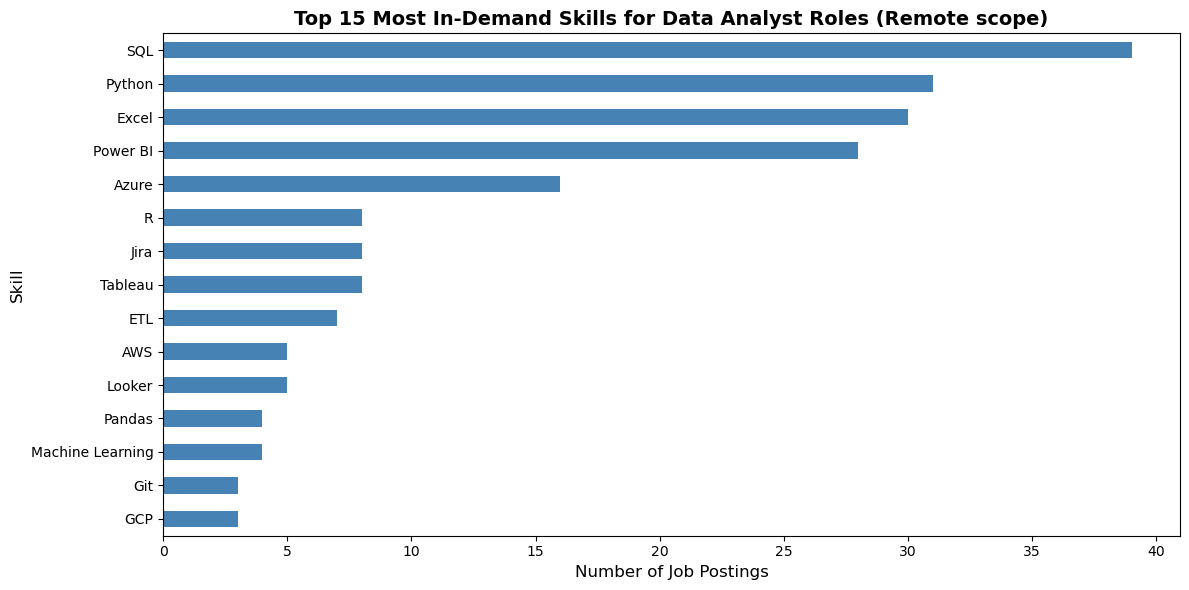


💡 Key insights (top 5):
• SQL: 39 jobs (39%)
• Python: 31 jobs (31%)
• Excel: 30 jobs (30%)
• Power BI: 28 jobs (28%)
• Azure: 16 jobs (16%)


In [65]:
# Visualize top skills with current scope (ALL or REMOTE)
import matplotlib.pyplot as plt

# Safety: handle empty or missing skill_counts
if 'skill_counts' in globals() and not skill_counts.empty:
    top_15_skills = skill_counts.head(15)
    total_jobs = len(df_jobs_full)
    scope_title = "Remote" if ('use_remote_scope' in globals() and use_remote_scope) else "All"

    plt.figure(figsize=(12, 6))
    top_15_skills.plot(kind='barh', color='steelblue')
    plt.title(f'Top 15 Most In-Demand Skills for Data Analyst Roles ({scope_title} scope)', fontsize=14, fontweight='bold')
    plt.xlabel('Number of Job Postings', fontsize=12)
    plt.ylabel('Skill', fontsize=12)
    plt.gca().invert_yaxis()  # Highest at top
    plt.tight_layout()
    plt.show()

    print("\n💡 Key insights (top 5):")
    print("=" * 60)
    for skill, count in top_15_skills.head(5).items():
        pct = (count / total_jobs) * 100 if total_jobs else 0
        print(f"• {skill}: {count} jobs ({pct:.0f}%)")
else:
    print("No skill counts available to visualize.")

In [66]:
# Save data to CSV and Azure PostgreSQL database
scope_suffix = 'remote_' if ('use_remote_scope' in globals() and use_remote_scope) else ''
filename = f"reed_{scope_suffix}data_analyst_jobs_with_skills.csv"

df_jobs_full['skills_list'] = df_jobs_full['skills'].apply(lambda x: ', '.join(x) if len(x) > 0 else '')
df_jobs_full.to_csv(filename, index=False)
print(f"✅ Full job data with extracted skills saved to {filename}")

# Save to Azure PostgreSQL database
from sqlalchemy import create_engine
import urllib.parse

# Azure PostgreSQL connection details
password = urllib.parse.quote_plus("Catherin3!")
azure_connection_string = (
    f"postgresql://gbadmin:{password}@"
    "dvdrental.postgres.database.azure.com:5432/"
    "postgres?sslmode=require"
)

print("Attempting to connect to Azure PostgreSQL...")
try:
    engine = create_engine(azure_connection_string, connect_args={
        'connect_timeout': 10,
        'options': '-c statement_timeout=30000'
    })
    
    # Test the connection
    with engine.connect() as conn:
        print("✓ Connection successful!")
    
    # Save to 'jobs' table in Azure
    print(f"Saving {len(df_jobs_full)} rows to Azure PostgreSQL table 'jobs'...")
    df_jobs_full.to_sql('jobs', engine, if_exists='replace', index=False)
    print(f"✅ Data saved to Azure PostgreSQL table 'jobs'")
    
except Exception as e:
    print(f"❌ Failed to connect to Azure PostgreSQL:")
    print(f"Error: {str(e)}")
    print("\nPossible issues:")
    print("1. Firewall: Your IP might not be whitelisted in Azure")
    print("2. Server: The server might be paused or unavailable")
    print("3. Credentials: Username/password might be incorrect")
    print("4. SSL: Connection requires SSL certificate")
    print("\nData is still saved locally to CSV.")

✅ Full job data with extracted skills saved to reed_remote_data_analyst_jobs_with_skills.csv
Attempting to connect to Azure PostgreSQL...
✓ Connection successful!
Saving 100 rows to Azure PostgreSQL table 'jobs'...
✓ Connection successful!
Saving 100 rows to Azure PostgreSQL table 'jobs'...
✅ Data saved to Azure PostgreSQL table 'jobs'
✅ Data saved to Azure PostgreSQL table 'jobs'


In [67]:
# Preview the active dataset (scope-aware) with nicer display
import pandas as pd
from IPython.display import display

# Choose which DF to show (in priority order)
if 'df_jobs_full' in globals():
    target_df = df_jobs_full
    name = 'df_jobs_full'
elif 'df_remote_jobs' in globals() and isinstance(df_remote_jobs, pd.DataFrame) and not df_remote_jobs.empty:
    target_df = df_remote_jobs
    name = 'df_remote_jobs'
elif 'df_jobs' in globals():
    target_df = df_jobs
    name = 'df_jobs'
else:
    target_df = None

if target_df is None:
    print('No DataFrame is available to preview yet. Run the earlier cells first.')
else:
    with pd.option_context('display.max_rows', 200,
                           'display.max_columns', None,
                           'display.width', 0,
                           'display.max_colwidth', None):
        n = len(target_df)
        k = min(200, n)
        print(f"Showing {k} of {n} rows from {name}. Use .head(), .tail(), or the VS Code Data Viewer for more.")
        display(target_df.head(k))

Showing 100 of 100 rows from df_jobs_full. Use .head(), .tail(), or the VS Code Data Viewer for more.


employerId                            employerName     jobId  \
0       645147                             Vermelo RPO  56061055   
1       524744     Hays Specialist Recruitment Limited  56060755   
2       524744     Hays Specialist Recruitment Limited  56060755   
3       612529                   Randstad Technologies  56058423   
4       601455                        Pertemps Cardiff  56055119   
5       576711                     Pertemps SSDC - DDT  56055128   
6       409660                                  Huxley  56055138   
7       331522  Harnham - Data & Analytics Recruitment  56047975   
8       693517                                JudeLuxe  56046079   
9       472032                  Proactive Appointments  56047468   
10      595947                      Avencia Consulting  56038081   
11      595844                      The Wildlife Trust  56036497   
12      645147                             Vermelo RPO  56038622   
13      427350                     Ascent Sourcing Ltd  56034872   
14      398340      Profile Search &amp; Selection Ltd  55876705   
15      487981                   Meraki Talent Limited  56029513   
16      364620                         Alexander Lloyd  56025514   
17        2250                   Harcourt Matthews Ltd  56019705   
18      563845                                 Adecco   56021069   
19      464685                                  Lorien  56020066   
20      563988                                 Pontoon  56019637   
21      447920                               Klipboard  56011603   
22      397873                            Forward Role  56014684   
23      501625                         BCT Resourcing   56009669   
24       82051   Bentley Whitaker Search and Selection  55855753   
25      398340      Profile Search &amp; Selection Ltd  55849540   
26      682867                              GroupNexus  54927790   
27      645147                             Vermelo RPO  56125782   
28      618887                            Virgin Money  56117325   
29      331522  Harnham - Data & Analytics Recruitment  56075994   
30      464401                         ACS Performance  56107256   
31      331522  Harnham - Data & Analytics Recruitment  56084663   
32      332753                                    Noir  56121382   
33      336199                         Project Recruit  55978602   
34      633103                                 Crimson  56100837   
35       17696                 TXP Technology x People  56118120   
36      575264                                    Reed  56069981   
37      686075                              MYO Talent  56097393   
38      651902          Pertemps Newcastle & Gateshead  56124071   
39      331522  Harnham - Data & Analytics Recruitment  56068032   
40      437172                              Matchtech   56118157   
41      331522  Harnham - Data & Analytics Recruitment  55957720   
42      686075                              MYO Talent  56114152   
43      575264                                    Reed  56104734   
44      604739                  Appoint Consulting ltd  55987733   
45      331522  Harnham - Data & Analytics Recruitment  56122011   
46      352810                                     ARC  55977889   
47      664120                             Robert Half  55998202   
48      331522  Harnham - Data & Analytics Recruitment  56001578   
49      431313              Sphere Digital Recruitment  56104861   
50        7337                           Ashdown Group  56118231   
51        7337                           Ashdown Group  56118228   
52        7337                           Ashdown Group  56118224   
53      523815                              Morgan Law  55968247   
54      386425    Carrington Recruitment Solutions Ltd  55993084   
55      624591                 Davies Talent Solutions  56081869   
56      520034                               Sanderson  56070784   
57      377106                          Robert Walters  5611

---
## Troubleshooting: Azure Database Connection

If the Azure save fails, use the cell below to diagnose the connection issue.

In [68]:
# DIAGNOSTIC: Test Azure PostgreSQL connection and list tables
import psycopg2

print("Testing Azure PostgreSQL connection...\n")

try:
    conn = psycopg2.connect(
        host="dvdrental.postgres.database.azure.com",
        port=5432,
        database="postgres",
        user="gbadmin",
        password="Catherin3!",
        sslmode="require",
        connect_timeout=10
    )
    
    print("✅ Connection successful!")
    
    # List tables
    cursor = conn.cursor()
    cursor.execute("""
        SELECT table_schema, table_name 
        FROM information_schema.tables 
        WHERE table_schema NOT IN ('information_schema', 'pg_catalog')
        ORDER BY table_schema, table_name;
    """)
    
    tables = cursor.fetchall()
    
    if tables:
        print(f"\nFound {len(tables)} table(s):")
        print("-" * 60)
        for schema, table in tables:
            print(f"  {schema}.{table}")
            
            # Get row count for this table
            cursor.execute(f'SELECT COUNT(*) FROM "{schema}"."{table}";')
            count = cursor.fetchone()[0]
            print(f"    → {count:,} rows")
    else:
        print("\nNo user tables found - database is empty")
    
    cursor.close()
    conn.close()
    
except psycopg2.OperationalError as e:
    print(f"❌ Connection failed: {e}")
    print("\nThis confirms Python cannot connect even though VS Code can.")
    print("VS Code likely uses Azure AD authentication or a connection tunnel.")
    print("\nTo fix this, check Azure Portal:")
    print("  1. Server Overview → ensure server is 'Available'")
    print("  2. Networking → Public access must be enabled")
    print("  3. Networking → Firewall rules → verify your IP is listed")
    print("  4. Connection security → Check authentication method")
    
except Exception as e:
    print(f"❌ Unexpected error: {e}")

Testing Azure PostgreSQL connection...

✅ Connection successful!

Found 3 table(s):
------------------------------------------------------------
  cron.job
✅ Connection successful!

Found 3 table(s):
------------------------------------------------------------
  cron.job
    → 0 rows
  cron.job_run_details
    → 0 rows
  public.jobs
    → 100 rows
    → 0 rows
  cron.job_run_details
    → 0 rows
  public.jobs
    → 100 rows
